In [1]:
from utils_2d import *
from utils import *
from matplotlib import pyplot as plt
import numpy as np
import cv2 as cv
from skimage.metrics import structural_similarity as ssim

In [2]:
setup = {
    'N': 5000,
    'L': 4e-3, # 8mm
    'lambda_0': 650e-9, # 650nm, red light
    'f1': 0.045, # 45mm
    'f2': 0.025, # 25mm
    'A': 0.005, # 5mm
    'plot': False
}
N = setup['N']
n = 1024
signal = np.asarray(cv.imread('./test_images/siemens_2048.bmp', cv.IMREAD_GRAYSCALE))
field = np.zeros((N, N), dtype=np.complex128)
field = center_splice_2d(field, signal)
# plt.imshow(np.abs(field), cmap='gray')

In [3]:
# compute coordinates for aperture field
kx = np.fft.fftfreq(setup['N'], d=setup['L']/setup['N'])
kx = np.fft.fftshift(kx)*setup['lambda_0']*setup['f1']

A_samples = int((setup['A'] / (np.max(kx) - np.min(kx))) * setup['N'])

In [4]:
n_leds = 5
n_samples_led = 5000
size_led = 223e-3
spacing = 4e-3
led_fwhm = 0.1e-3

# generate array of images

images = []
for i, (index, x) in enumerate(led_array_2d(n_leds, n_samples_led, size_led, spacing, led_fwhm)):
    # compute illumination, propagate to object plane
    x_out, _ = propagate_fft_2d(x)
    x_field = np.zeros((N, N), dtype=np.complex128)
    x_field = center_splice_2d(x_field, x_out)
    
    # compute object field
    object_field = x_field * field
    
    # image object
    img = image_2d(object_field, setup)
        
    img_amp = np.abs(img) # output image amplitude, same as sqrt(intensity(image(object, setup))
    images.append((index, img_amp))
    
#  offset due to plane wave (precalculated)
offset = -147 #np.abs((np.array(np.subtract(np.unravel_index(np.argmax(x), x.shape), (n_samples_led//2, n_samples_led//2))) / n_samples_led) * N).astype(int)


In [5]:
import importlib
import utils_2d
importlib.reload(utils_2d)

<module 'utils_2d' from '/Users/corey/Documents/Project/simple_sim/utils_2d.py'>

In [10]:
output = utils_2d.reconstruct_gs_2d(images, offset, N, 3)
output_img = ifftshift(ifft2(ifftshift(output)))

In [11]:
# plt.imshow(np.abs(output_img), cmap='gray')
cv.imwrite('./test_output/siemens_2048_recon.bmp', 256*np.abs(normalize(output_img)))

True

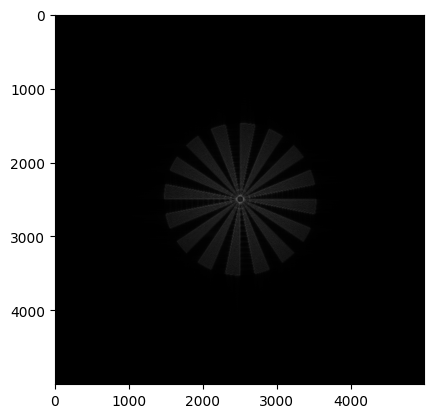

In [8]:
plt.imshow(np.abs(normalize(output_img)), cmap='gray')

0.3007422441340312


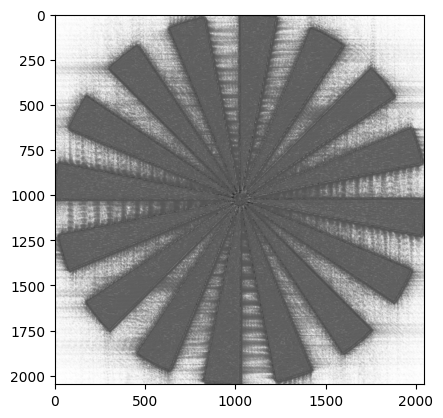

In [9]:
field_cropped = center_cut_2d(np.abs(normalize(field)), signal.shape[0])
output_img_cropped = center_cut_2d(np.abs(normalize(output_img)), signal.shape[0])
(score, diff) = ssim(field_cropped, output_img_cropped, full=True, gaussian_weights=True, sigma=1.5, use_sample_covariance=False, data_range=1.0)
score
plt.imshow(diff, cmap='gray')
print(score)